In [ ]:
#INSTALLING LIBRARIES
!pip install torch torchvision torchaudio
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
#IMPORTING LIBRARIES
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
#DEVICE CONFIGURATION (Clip & Blip are GPU-accelerated)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


In [ ]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))

CUDA available: False


In [ ]:
#LOAD CLIP MODEL
model, preprocess = clip.load("ViT-B/32", device=device)   #ViT-B/32 is stable, lightweight, and well-documented
                                                           #preprocess ensures image matches CLIP training format
model.eval()                                               #disables training behavior


Text(0.5, 1.0, 'Anonymized Sentinel-2 True Color Image')

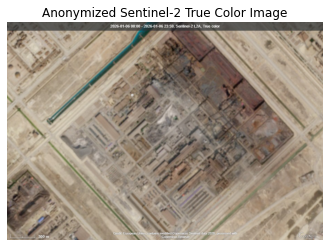

In [ ]:
#LOAD AND DISPLAY SATELLITE IMAGE
image_path = "image.jpg"
image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.axis("off")
plt.title("Anonymized Sentinel-2 True Color Image")


In [ ]:
#PREPROCESS IMAGE FOR CLIP
#resize, normalize,tensorize,add batch dimension
image_input = preprocess(image).unsqueeze(0).to(device)


In [ ]:
#DEFINE SUSTAINABILITY CLAIMS
text_descriptions = [
    "The company has committed to reducing routine gas flaring as part of sustainability initiatives.",
    "The satellite image shows visible gas flaring near an industrial facility.",
    "Operations are conducted with minimal environmental impact."
    "The site shows visible emissions and industrial activity."
]


In [ ]:
#ENCODE TEXT USING CLIP
text_tokens = clip.tokenize(text_descriptions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    image_features = model.encode_image(image_input)


In [ ]:
#NORMALIZE EMBEDDINGS
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)


In [ ]:
#COMPUTE SIMILARITY SCORES
similarity = (image_features @ text_features.T).cpu().numpy()[0]

for desc, score in zip(text_descriptions, similarity):
    print(f"{desc} -> similarity score: {score:.3f}")


The company has committed to reducing routine gas flaring as part of sustainability initiatives. -> similarity score: 0.206
The satellite image shows visible gas flaring near an industrial facility. -> similarity score: 0.296
Operations are conducted with minimal environmental impact.The site shows visible emissions and industrial activity. -> similarity score: 0.280


In [ ]:
#INTERPRET HIGHEST ALIGNMENT
best_match = text_descriptions[np.argmax(similarity)]
print("Highest alignment description:")
print(best_match)


Highest alignment description:
The satellite image shows visible gas flaring near an industrial facility.


In [ ]:
#INSTALL & IMPORT BLIP-2
!pip install transformers accelerate sentencepiece
from transformers import Blip2Processor, Blip2ForConditionalGeneration


In [ ]:
#LOAD BLIP-2 MODEL
from transformers import Blip2Processor, Blip2ForConditionalGeneration


processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float32
).to(device)

blip_model.eval()




In [ ]:
#BLIP-2 PROMPT
prompt = (
    "Describe the visible features of this satellite image in a neutral, "
    "observational manner without making assumptions or claims."
)


In [ ]:
#GENERATE BLIP-2 EXPLANATION
inputs = processor(image, prompt, return_tensors="pt").to(device)

with torch.no_grad():
    output = blip_model.generate(**inputs, max_new_tokens=60)

generated_text = processor.decode(output[0], skip_special_tokens=True)
print(generated_text)


In [ ]:
#FINAL INTERPRETATION
print(
    "This pilot demonstrates how Vision–Language Models can combine "
    "satellite imagery and textual descriptions to support multimodal "
    "sustainability assessment methodologies."
)
